In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

In [3]:
os.chdir('drive/MyDrive/Colab Notebooks/')

In [4]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import pandas as pd
import cv2
import os
import pickle
from skimage.color import rgb2gray
from PIL import Image
from google.colab.patches import cv2_imshow
import sys

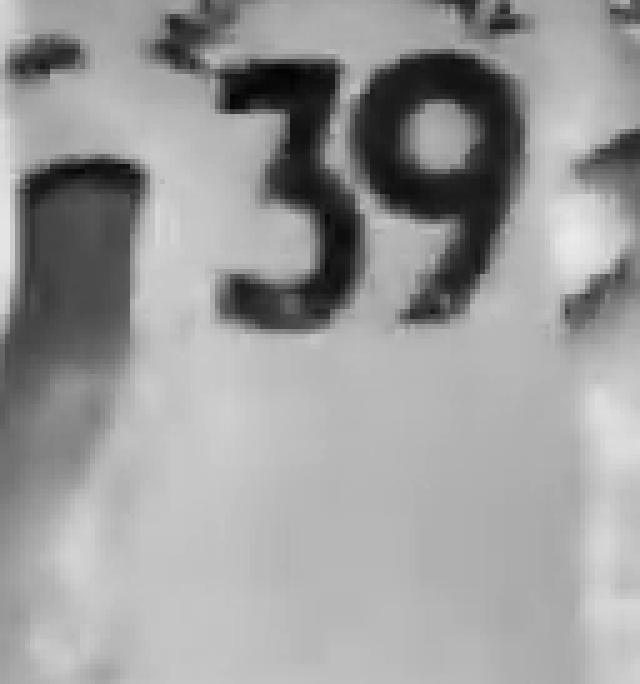

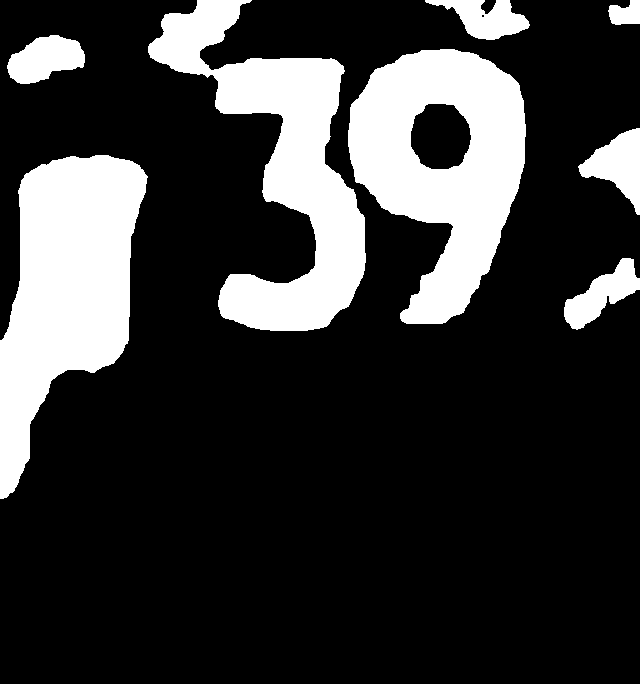

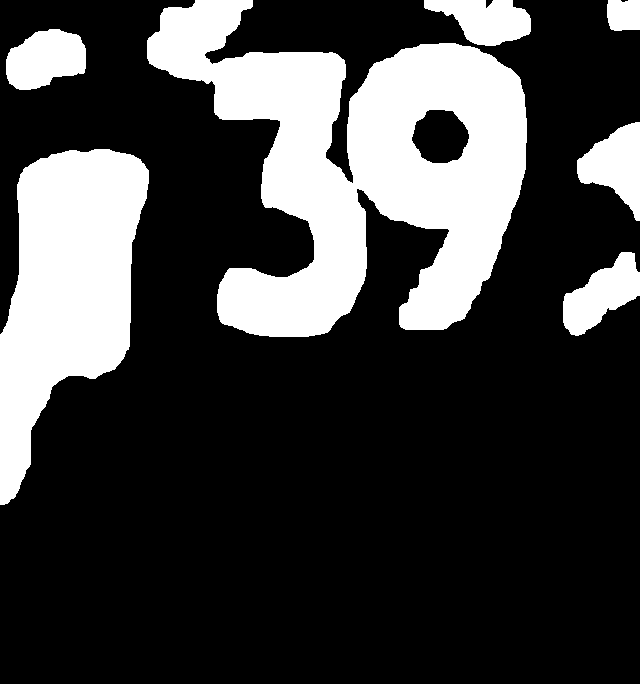

(147, 0, 380, 337)


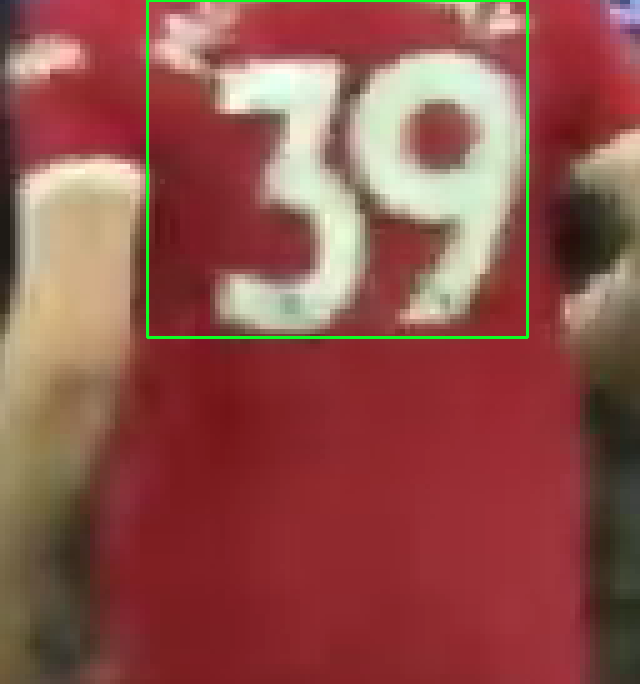

In [ ]:
# import pytesseract

img = Image.open('data/num_img4.png').convert('L')
img

img_rgb = cv2.imread('data/num_img3.png')
scale_percent = 500
width = int(img_rgb.shape[1] * scale_percent / 100)
height = int(img_rgb.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
img_rgb = cv2.resize(img_rgb, dim, interpolation = cv2.INTER_AREA)

hImg = img_rgb.shape[0]
wImg = img_rgb.shape[1]
img_rgb = img_rgb[hImg//10*2:hImg//10*5, wImg//100*10:wImg//100*90]

gray = ~ cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)
blur = cv2.GaussianBlur(gray, (7,7), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
cv2_imshow(thresh)
ret, mask = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,13))
dilate = cv2.dilate(thresh, kernel, iterations=1)
cv2_imshow(dilate)
# extractedInformation = pytesseract.image_to_string(Conv_hsv_Gray)
# extractedInformation
# img_rgb[mask == 255] = [0, 0, 255]

cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

cnts = sorted(cnts, key=lambda x:cv2.boundingRect(x)[0])
for c in cnts:
  x,y,w,h = cv2.boundingRect(c)
  if h>img_rgb.shape[0]//10*3 and w>img_rgb.shape[0]//10*3 and h<img_rgb.shape[0]//10*7 :
    print(cv2.boundingRect(c))
    cv2.rectangle(img_rgb, (x,y), (x+w, y+h), (36,255,12), 2)
  # cv2.rectangle(img_rgb, (x,y), (x+w, y+h), (36,255,12), 2)
cv2_imshow(img_rgb)





# cv2_imshow(mask)  # show windows

# hImg, wImg, _ = img_rgb.shape
# config = r'--oem 3 --psm 10 -c tessedit_char_whitelist=0123456789'
# boxes = pytesseract.image_to_boxes(img_rgb, config=config)
# for b in boxes.splitlines():
#   b = b.split(' ')
#   x, y, w, h = int(b[1]), int(b[2]), int(b[3]), int(b[4])
#   cv2.rectangle(img_rgb, (x, hImg - y), (w, hImg - h), (50, 50, 255), 1)
#   cv2.putText(img_rgb, b[0], (x, hImg - y + 13), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (50, 205, 50), 1)

# cv2_imshow(img_rgb)


# image = cv2.imread('data/num_img2.png')
# gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
# gray
# blur = cv2.GaussianBlur(gray,(5,5),0)
# thresh = cv2.adaptiveThreshold(blur,255,1,1,11,2)

# contours,hierarchy = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

# samples =  np.empty((0,100))
# responses = []
# keys = [i for i in range(48,58)]

# for cnt in contours:
#     if cv2.contourArea(cnt)>50:
#         [x,y,w,h] = cv2.boundingRect(cnt)
        
#         if  h>28:
#             cv2.rectangle(image,(x,y),(x+w,y+h),(0,0,255),2)
#             roi = thresh[y:y+h,x:x+w]
#             roismall = cv2.resize(roi,(10,10))
#             cv2_imshow(image)
#             key = cv2.waitKey(0)

#             if key == 27:  # (escape to quit)
#                 sys.exit()
#             elif key in keys:
#                 responses.append(int(chr(key)))
#                 sample = roismall.reshape((1,100))
#                 samples = np.append(samples,sample,0)

# responses = np.array(responses,np.float32)
# responses = responses.reshape((responses.size,1))

In [7]:
# import pytesseract
def detect_jersey_number(img):
  # cv2_imshow(img)
  bboxes = []
  scale_percent = 500

  imh = img.shape[0]
  imw = img.shape[1]

  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
    
  # resize image
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

  hImg = img.shape[0]
  wImg = img.shape[1]

  #crop
  img = img[hImg//10*2:hImg//10*5, wImg//100*10:wImg//100*90]
  # cv2_imshow(img)

  #grayscale
  gray = ~ cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # cv2_imshow(gray)

  #blur
  blur = cv2.GaussianBlur(gray, (7,7), 0)
  # cv2_imshow(blur)

  #threshold
  thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  # cv2_imshow(thresh)

  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,13))

  #dilate
  dilate = cv2.dilate(thresh, kernel, iterations=1)
  # cv2_imshow(dilate)

  #contours
  cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  cnts = sorted(cnts, key=lambda x:cv2.boundingRect(x)[0])
  
  for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    if h>img.shape[0]//10*3 and w>img.shape[0]//10*3 and h<img.shape[0]//10*7 :
      bboxes.append(((x+imw//2)//5,(y+imh)//5,w//5,h//5))
      # cv2.rectangle(img, (x,y), (x+w, y+h), (36,255,12), 2)
      # cv2_imshow(img[y:y+h,x:x+w])
      # text = pytesseract.image_to_string(img[x:x+w,y:y+h], config='digits')
      # print(f'text is : {text}')

  # cv2_imshow(img)
  return bboxes

In [8]:
detect_jersey_number(cv2.imread('data/num_img3.png'))

[(46, 91, 76, 67)]

In [9]:
digit_recognition_model = load_model('number_detection_model.h5')

In [14]:
def identify_number(img):
  digits=[]
  nr=0
  cropped_img=img
  width = int(cropped_img.shape[1] * 5)
  height = int(cropped_img.shape[0] * 5)
  dim = (width, height)
    
  # resize image
  cropped_img = cv2.resize(cropped_img, (dim), interpolation = cv2.INTER_AREA)
  # cv2_imshow(cropped_img)
  gray = ~ cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
  # cv2_imshow(gray)
  blur = cv2.GaussianBlur(gray, (7,7), 0)
  thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  # cv2_imshow(thresh)
  # cv2.rectangle(img, (x,y), (x+w, y+h), (36,255,12), 2)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,13))
  dilate = cv2.dilate(thresh, kernel, iterations=1)
  cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]

  cnts = sorted(cnts, key=lambda x:cv2.boundingRect(x)[0])
  for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    if h>cropped_img.shape[0]//10*5 and w>cropped_img.shape[0]//4:
      # cv2.rectangle(cropped_img, (x,y), (x+w, y+h), (36,255,12), 2)
      digit_img = cropped_img[y:y+h, x:x+w]
      # digit_img.resize()
      gray = cv2.cvtColor(digit_img, cv2.COLOR_BGR2GRAY)
      blur = cv2.GaussianBlur(gray, (7,7), 0)
      thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
      # thresh = cv2.copyMakeBorder(thresh, 20, 20, 20, 20, cv2.BORDER_REPLICATE)
      # cv2_imshow(thresh)
      digit_black_and_white_img = cv2.resize(thresh, (20,20), interpolation = cv2.INTER_AREA)
      digit_black_and_white_img = cv2.copyMakeBorder(digit_black_and_white_img, 4, 4, 4, 4, cv2.BORDER_CONSTANT,value=[255, 255, 255])
      # digit_black_and_white_img = np.full((28,28, 1), (255,255,255), dtype=np.uint8)
      # digit_black_and_white_img = digit_black_and_white_img/255
      # cv2_imshow(digit_black_and_white_img)
      text = pytesseract.image_to_string(cv2.copyMakeBorder(digit_black_and_white_img, 20, 20, 20, 20, cv2.BORDER_CONSTANT,value=[255, 255, 255]), config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')
      try:
        nr=int(text)
      except Exception:
        nr=None
      if nr:
        digits.append(nr)
      else:
      # print(pytesseract.image_to_string(~digit_black_and_white_img, config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789'))
        digit_black_and_white_img = np.expand_dims(digit_black_and_white_img, (0,3))
        # cv2_imshow(digit_black_and_white_img)
        # print(digit_black_and_white_img.shape)
        pred = digit_recognition_model.predict(digit_black_and_white_img)
        if pred[0][pred.argmax()]>0.7:
          digits.append(pred.argmax())
  number = "".join([str(digit) for digit in digits])
  return number

In [16]:
identify_number(cv2.imread('data/num_img5.png'))

''

(28, 28)


(28, 28)


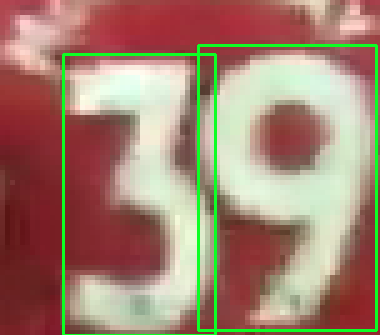

[3, 9]
39


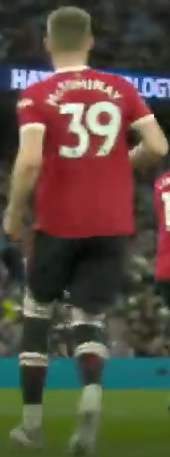

In [17]:
import pytesseract
img = cv2.imread('data/num_img3.png')
digits=[]
# cv2_imshow(img)
nr=0
for bbox in detect_jersey_number(img):
  x,y,w,h = bbox[0], bbox[1], bbox[2], bbox[3]
  cropped_img = img[y:y+h, x:x+w]
  cv2.imwrite('cropped.png', cropped_img)
  width = int(cropped_img.shape[1] * 5)
  height = int(cropped_img.shape[0] * 5)
  dim = (width, height)
    
  # resize image
  cropped_img = cv2.resize(cropped_img, (dim), interpolation = cv2.INTER_AREA)
  # cv2_imshow(cropped_img)
  gray = ~ cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
  # cv2_imshow(gray)
  blur = cv2.GaussianBlur(gray, (7,7), 0)
  thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  # cv2_imshow(thresh)
  # cv2.rectangle(img, (x,y), (x+w, y+h), (36,255,12), 2)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,13))
  dilate = cv2.dilate(thresh, kernel, iterations=1)
  cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]

  cnts = sorted(cnts, key=lambda x:cv2.boundingRect(x)[0])
  for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    if h>img.shape[0]//10*3 and w>img.shape[0]//10*3:
      cv2.rectangle(cropped_img, (x,y), (x+w, y+h), (36,255,12), 2)
      digit_img = cropped_img[y:y+h, x:x+w]
      # digit_img.resize()
      gray = cv2.cvtColor(digit_img, cv2.COLOR_BGR2GRAY)
      blur = cv2.GaussianBlur(gray, (7,7), 0)
      thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
      # thresh = cv2.copyMakeBorder(thresh, 20, 20, 20, 20, cv2.BORDER_REPLICATE)
      # cv2_imshow(thresh)
      digit_black_and_white_img = cv2.resize(thresh, (20,20), interpolation = cv2.INTER_AREA)
      digit_black_and_white_img = cv2.copyMakeBorder(digit_black_and_white_img, 4, 4, 4, 4, cv2.BORDER_CONSTANT,value=[255, 255, 255])
      # digit_black_and_white_img = np.full((28,28, 1), (255,255,255), dtype=np.uint8)
      # digit_black_and_white_img = digit_black_and_white_img/255
      print(digit_black_and_white_img.shape)
      cv2_imshow(digit_black_and_white_img)
      text = pytesseract.image_to_string(cv2.copyMakeBorder(digit_black_and_white_img, 20, 20, 20, 20, cv2.BORDER_CONSTANT,value=[255, 255, 255]), config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')
      try:
        nr=int(text)
      except Exception:
        nr=None
      if nr:
        digits.append(nr)
      else:
      # print(pytesseract.image_to_string(~digit_black_and_white_img, config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789'))
        digit_black_and_white_img = np.expand_dims(digit_black_and_white_img, (0,3))
        # cv2_imshow(digit_black_and_white_img)
        # print(digit_black_and_white_img.shape)
        pred = digit_recognition_model.predict(digit_black_and_white_img)
        if pred[0][pred.argmax()]>0.7:
          digits.append(pred.argmax())
        # print(pred.argmax())
  cv2_imshow(cropped_img)
  print(digits)
  number = "".join([str(digit) for digit in digits])
  print(number)
  # cv2.imwrite('digitimg.png', cropped_img)
cv2_imshow(img)

(28, 28)


1/1 [==============================] - 0s 21ms/step


3

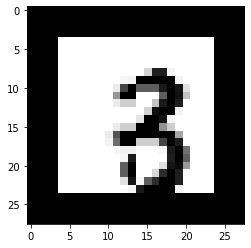

In [ ]:

img = cv2.imread("3.png")
# cv2_imshow(img)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# cv2_imshow(gray)
gray.shape
img = np.zeros_like(img)
img[:,:,0] = gray
img[:,:,1] = gray
img[:,:,2] = gray
# img = cv2.resize(img,(28,28))
# img = img[:,:,0].reshape(28,28)
# pred = digit_recognition_model.predict(img.reshape(1,28,28,1))
# print(pred.argmax())
# img.shape
# img = img[:,:,0]

blur = cv2.GaussianBlur(gray, (3,3), 1)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
thresh = cv2.resize(thresh, (20,20))
thresh = cv2.copyMakeBorder(thresh,top=4,bottom=4,left=4,right=4,borderType=cv2.BORDER_CONSTANT,value=[255, 255, 255])
print(thresh.shape)
# thresh = thresh.reshape(28,28)
cv2_imshow(thresh)
# thresh = thresh/255
plt.imshow(thresh,cmap='Greys')
# cv2_imshow(thresh)
# thresh = thresh.reshape(1,28,28,1)
pred = digit_recognition_model.predict(thresh.reshape(1,28,28,1))
pred.argmax()
# thresh

# img[:,:,1] = gray
# img[:,:,2] = gray
# # cv2_imshow(img[:,:,0])
# copyimg=img[:,:,0]
# copyimg = np.expand_dims(copyimg, 2)
# copyimg.shape
# cv2_imshow(copyimg)

# image = cv2.GaussianBlur(cv2.resize(img, dsize=(28, 28)), (5,5), 0)
# # image.shape
# image = image / 255.0
# image = np.expand_dims(image, (0,3))
# image.shape
# pred = digit_recognition_model.predict(image)
# digit = np.argmax(pred)
# digit
# for i in pred:
#   if pred[i]>0.4:
#     print(i)
# img = cv2.resize(img,(28,28))
# img.shape
# img = img/255
# img.shape
# cv2_imshow(img)

In [ ]:
img = cv2.imread("3.png")[:,:,0]
img=~cv2.resize(img,(20,20))
img = img.astype('float32')
print(img.shape)
# img= np.invert(np.array([img]))
img = cv2.copyMakeBorder(img,top=4,bottom=4,left=4,right=4,borderType=cv2.BORDER_CONSTANT,value=[255, 255, 255])
cv2_imshow(img)
pred = digit_recognition_model.predict(img.reshape(1,28,28,1))
pred.argmax()
# img = cv2.resize(~cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), (28,28))
# img.shape
# img = img/255
# plt.imshow(img,cmap='Greys')
# pred = digit_recognition_model.predict(img.reshape(1,28,28,1))
# pred.argmax()

# img.reshape(28,28)
# cv2_imshow(img)
# blur = cv2.GaussianBlur(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), (3,3), 1)
# thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
# cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).shape

(20, 20)


1/1 [==============================] - 0s 20ms/step


3

In [18]:
def count_nonblack_pixels(img):
    return img.any(axis=-1).sum()

In [19]:
def detect_team(image):
    # define the list of boundaries
    color_list=['red','yellow','blue']
    ratios = []
    boundaries = [
    ([17, 15, 100], [50, 56, 200]), #red
    ([25, 146, 190], [96, 174, 250]), #yellow
    ([43, 31, 4], [250, 88, 50]), #blue
    ]
    i = 0
    for (lower, upper) in boundaries:
        # create NumPy arrays from the boundaries
        lower = np.array(lower, dtype = "uint8")
        upper = np.array(upper, dtype = "uint8")

        # find the colors within the specified boundaries and apply
        # the mask
        # print(image.shape)
        mask = cv2.inRange(image, lower, upper)
        output = cv2.bitwise_and(image, image, mask = mask)
        tot_pix = count_nonblack_pixels(image)
        color_pix = count_nonblack_pixels(output)
        ratio = color_pix/tot_pix
        ratios.append(ratio)
        i += 1
    # print(ratios)
    # print(np.max(ratios))
    if np.max(ratios) < 0.015:
      return 'not sure'   
    return color_list[np.argmax(ratios)]

In [20]:
writer = None

h, w = None, None

min_prob = 0.5

colors={
    'blue':(255,0,0),
    'red':(0,0,255),
    'green':(0,255,0),
    'yellow':(0,255,255),
}

video = cv2.VideoCapture('data/input_video.mp4')

network = cv2.dnn.readNet('yolov3.weights','darknet/cfg/yolov3.cfg')
network.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)

ln = network.getLayerNames()
ln = [ln[i - 1] for i in network.getUnconnectedOutLayers()]

frames=0
while True:
  frames += 1
  if frames > 50:
    break
  ret, frame = video.read()
  if not ret:
      break
  
  # if w is None or h is None:
  #     # Slicing and get height, width of the image
  #     Height, Width = frame.shape[:2]

  boxes = []
  box_colors = []
  bboxes={}
  confidences = []
  classIDs = []
  h, w = frame.shape[:2]
  
  blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
  network.setInput(blob)
  outputs = network.forward(ln)

  for output in outputs:
      for detection in output:
          scores = detection[5:]
          classID = np.argmax(scores)
          confidence = scores[classID]


          if confidence > 0.5:
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = [x, y, int(width), int(height)]

            player_image = frame[y:y+int(height), x:x+int(width)]
            if player_image.shape[0] == 0 or player_image.shape[1] == 0 or player_image.shape[2] == 0:
                    continue
            boxes.append(box)
            confidences.append(float(confidence))
            classIDs.append(classID)

            color = detect_team(player_image)
            box_colors.append(color) 
            # print(color)
            try:
              number_bboxes = detect_jersey_number(player_image)
              for b in number_bboxes:
                X,Y,W,H = b[0], b[1], b[2], b[3]
                number = identify_number(frame[y+Y:y+Y+H, x+X:x+X+W])
                cv2.rectangle(frame, (x+X,y+Y), (x+X+W, y+Y+H), (36,255,12), 2)
                cv2.putText(frame, f'Number {number}',(x-10, y-20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)
              bboxes[len(boxes)-1] = number_bboxes
            except Exception:
              pass
            cv2_imshow(player_image)
            
  indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
  if len(indices) > 0:
    for i in indices.flatten():
          box = boxes[i]

          if classIDs[i] == 0:
              color = (0, 0, 0)
              text = 'GK/REF'
              if box_colors[i] != 'not sure':
                color = colors[box_colors[i]]
              if box_colors[i] == 'red':
                text = 'Belgium'
              if box_colors[i] == 'blue':
                text = 'France'
              if box_colors[i] == 'yellow':
                text = 'GK'
              print(color)
              cv2.rectangle(frame, (round(box[0]),round(box[1])), (round(box[0]+box[2]),round(box[1]+box[3])), color, 2)
              cv2.putText(frame, text, (round(box[0])-10,round(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


  if writer is None:
        resultVideo = cv2.VideoWriter_fourcc(*'mp4v')

        # Writing current processed frame into the video file
        writer = cv2.VideoWriter('data/output_video.mp4', resultVideo, 24.0,
                                (frame.shape[1], frame.shape[0]), True)

  # Write processed current frame to the file
  writer.write(frame)

# Releasing video reader and writer
video.release()
writer.release()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
detect_team(cv2.imread('data/gk_img.png'))

[0.0, 0.0, 0.0]


'not sure'